<a href="https://colab.research.google.com/github/dishant9210/Max_Health/blob/main/final_derma_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


>>> Pipeline Start: GCE + Label Smoothing
DATASET INFORMATION
Training samples: 7007
Validation samples: 1003
Number of classes: 7



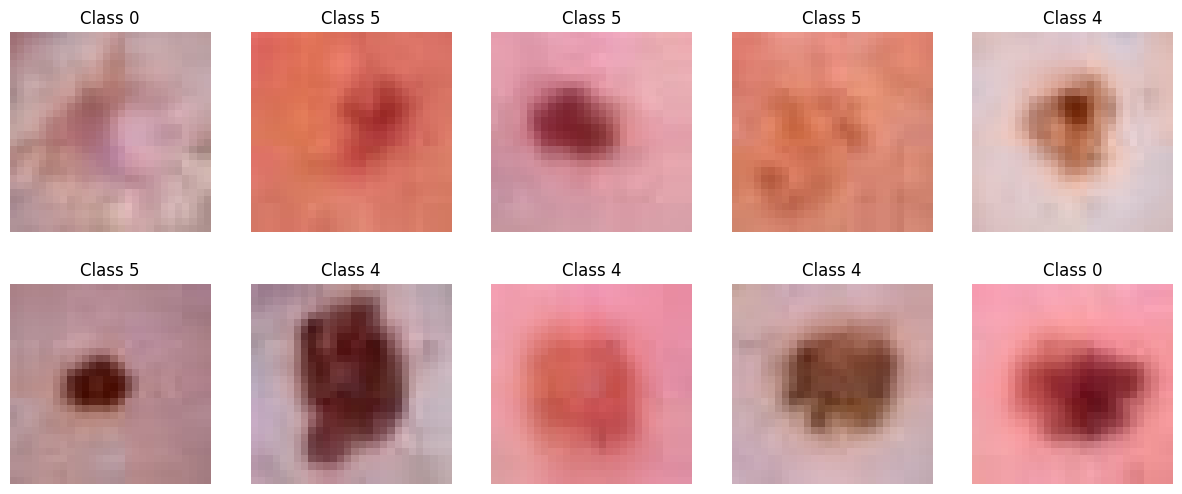

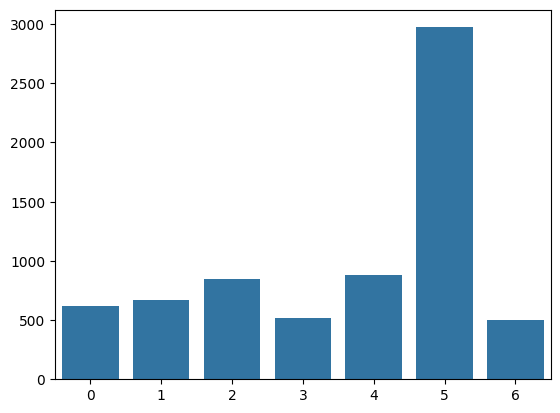

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.1839 - loss: 1.0701 - val_accuracy: 0.0678 - val_loss: 1.0858
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3037 - loss: 1.0427 - val_accuracy: 0.2532 - val_loss: 1.0400
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3283 - loss: 1.0401 - val_accuracy: 0.2522 - val_loss: 1.0276
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3100 - loss: 1.0435 - val_accuracy: 0.3360 - val_loss: 1.0090
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3246 - loss: 1.0314 - val_accuracy: 0.5095 - val_loss: 0.8365
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3278 - loss: 1.0288 - val_accuracy: 0.5184 - val_loss: 0.8083
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3280 - loss: 1.0308 - val_accuracy: 0.5474 - val_loss: 0.6826
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3273 - loss: 1.0303 - val_accu

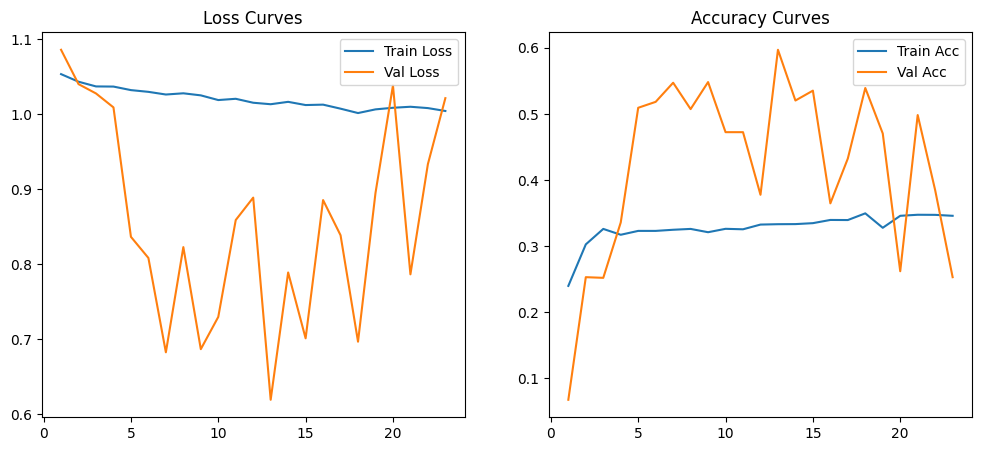


Evaluation - Loss: 0.6194, Accuracy: 59.72%


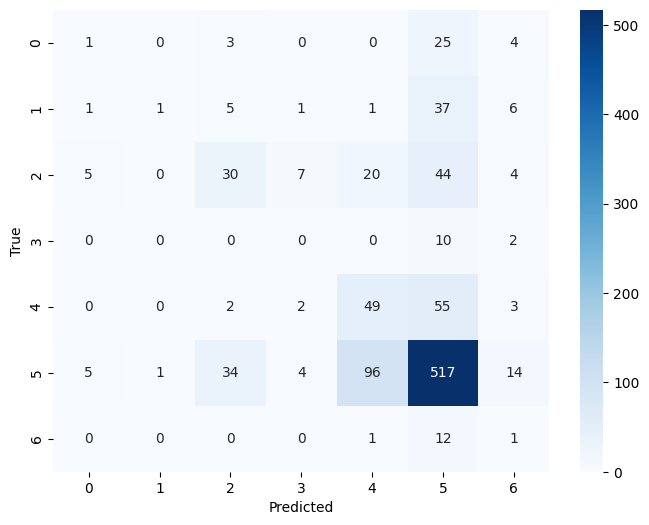

              precision    recall  f1-score   support

           0       0.08      0.03      0.04        33
           1       0.50      0.02      0.04        52
           2       0.41      0.27      0.33       110
           3       0.00      0.00      0.00        12
           4       0.29      0.44      0.35       111
           5       0.74      0.77      0.75       671
           6       0.03      0.07      0.04        14

    accuracy                           0.60      1003
   macro avg       0.29      0.23      0.22      1003
weighted avg       0.60      0.60      0.58      1003



In [3]:
"""
Max Healthcare - AI Engineer Assignment
Dermatology Image Classification with Noisy Labels

Author: Dishant
Approach: Generalized Cross-Entropy Loss + Label Smoothing + Robust Architecture
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K, callbacks
from sklearn.metrics import confusion_matrix, classification_report
import os

# ============================================================================
# CUSTOM LOSS FUNCTION: Generalized Cross-Entropy (GCE) with Label Smoothing
# ============================================================================

class GeneralizedCrossEntropy(tf.keras.losses.Loss):
    """
    Generalized Cross-Entropy Loss for robust learning with noisy labels.
    Enhanced with Label Smoothing to prevent overconfidence.

    Args:
        q: Robustness parameter (0 < q < 1). Higher q -> more robust to noise.
        num_classes: Number of target classes.
        label_smoothing: Float in [0, 1]. If > 0, smooths the one-hot labels.
    """
    def __init__(self, q=0.7, num_classes=7, label_smoothing=0.1, name='gce_loss', **kwargs):
        super().__init__(name=name, **kwargs)
        self.q = q
        self.num_classes = num_classes
        self.label_smoothing = label_smoothing

    def call(self, y_true, y_pred):
        # Clip predictions to avoid log(0) or numerical instability
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1.0)

        # Convert sparse labels to one-hot
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.reshape(y_true, [-1])
        y_true_one_hot = tf.one_hot(y_true, depth=self.num_classes)

        # Apply Label Smoothing
        if self.label_smoothing > 0:
            y_true_one_hot = y_true_one_hot * (1.0 - self.label_smoothing) + \
                             (self.label_smoothing / self.num_classes)

        # Get weighted predicted probability for the smoothed true classes
        p_y = tf.reduce_sum(y_true_one_hot * y_pred, axis=-1)

        # GCE formula: (1 - p^q) / q
        loss = (1.0 - tf.pow(p_y, self.q)) / self.q
        return loss

    def get_config(self):
        config = super().get_config()
        config.update({
            "q": self.q,
            "num_classes": self.num_classes,
            "label_smoothing": self.label_smoothing
        })
        return config


# ============================================================================
# DATA LOADING AND VALIDATION
# ============================================================================

def load_and_validate_dataset(filepath='candidate_dataset.npz'):
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Dataset not found: {filepath}")

    data = np.load(filepath)
    required_keys = ['x_train', 'y_train', 'x_val', 'y_val']
    missing_keys = [k for k in required_keys if k not in data.files]
    if missing_keys:
        raise ValueError(f"Missing required keys: {missing_keys}")

    print("=" * 60)
    print("DATASET INFORMATION")
    print("=" * 60)
    print(f"Training samples: {data['x_train'].shape[0]}")
    print(f"Validation samples: {data['x_val'].shape[0]}")
    print(f"Number of classes: {len(np.unique(data['y_train']))}")
    print("=" * 60 + "\n")
    return data


# ============================================================================
# EXPLORATORY DATA ANALYSIS
# ============================================================================

def perform_eda(x_train, y_train, save_plots=True):
    y_train_flat = y_train.flatten()

    # Plot sample images
    fig1, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(x_train[i])
        ax.set_title(f"Class {y_train_flat[i]}")
        ax.axis('off')
    if save_plots: plt.savefig('eda_samples.png')
    plt.show()

    # Class distribution
    class_counts = np.bincount(y_train_flat)
    sns.barplot(x=list(range(len(class_counts))), y=class_counts)
    if save_plots: plt.savefig('eda_distribution.png')
    plt.show()

    # Compute weights
    class_weights = {i: len(y_train_flat) / (len(class_counts) * count)
                    for i, count in enumerate(class_counts)}
    return class_weights


# ============================================================================
# DATA PREPARATION
# ============================================================================

def prepare_dataset(x, y, batch_size=64, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    if shuffle: ds = ds.shuffle(1000)
    ds = ds.map(lambda xi, yi: (xi, tf.cast(yi, tf.int32)))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


# ============================================================================
# MODEL ARCHITECTURE
# ============================================================================

def build_robust_model(input_shape=(28, 28, 3), num_classes=7):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Rescaling(1./255),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),

        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ], name='RobustCNN')
    return model


# ============================================================================
# EVALUATION AND VISUALIZATION
# ============================================================================

def plot_training_curves(history, save_path='training_dashboard.png'):
    epochs = range(1, len(history.history['loss']) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(epochs, history.history['loss'], label='Train Loss')
    ax1.plot(epochs, history.history['val_loss'], label='Val Loss')
    ax1.set_title('Loss Curves'); ax1.legend()

    ax2.plot(epochs, history.history['accuracy'], label='Train Acc')
    ax2.plot(epochs, history.history['val_accuracy'], label='Val Acc')
    ax2.set_title('Accuracy Curves'); ax2.legend()

    plt.savefig(save_path); plt.show()

def run_evaluation(model_path, data_path, verbose=True):
    model = tf.keras.models.load_model(
        model_path,
        custom_objects={'GeneralizedCrossEntropy': GeneralizedCrossEntropy}
    )
    data = np.load(data_path)
    x_eval, y_eval = data.get('x_val'), data.get('y_val')

    loss, accuracy = model.evaluate(x_eval, y_eval, verbose=0)
    y_pred = np.argmax(model.predict(x_eval, verbose=0), axis=1)

    if verbose:
        print(f"\nEvaluation - Loss: {loss:.4f}, Accuracy: {accuracy*100:.2f}%")
    return {'accuracy': accuracy, 'loss': loss, 'predictions': y_pred}

def plot_confusion_matrix(model_path, data_path):
    results = run_evaluation(model_path, data_path, verbose=False)
    data = np.load(data_path)
    y_true = data['y_val'].flatten()

    cm = confusion_matrix(y_true, results['predictions'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.show()
    print(classification_report(y_true, results['predictions']))


# ============================================================================
# MAIN TRAINING PIPELINE
# ============================================================================

def main(data_path='candidate_dataset.npz'):
    print("\n>>> Pipeline Start: GCE + Label Smoothing")

    data = load_and_validate_dataset(data_path)
    class_weights = perform_eda(data['x_train'], data['y_train'])

    train_ds = prepare_dataset(data['x_train'], data['y_train'], shuffle=True)
    val_ds = prepare_dataset(data['x_val'], data['y_val'])

    model = build_robust_model()

    # Compilation with GCE and Label Smoothing
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=GeneralizedCrossEntropy(q=0.7, num_classes=7, label_smoothing=0.1),
        metrics=['accuracy']
    )

    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        train_ds, validation_data=val_ds,
        epochs=50, class_weight=class_weights,
        callbacks=[early_stop]
    )

    model_path = 'robust_gce_model.keras'
    model.save(model_path)

    plot_training_curves(history)
    run_evaluation(model_path, data_path)
    plot_confusion_matrix(model_path, data_path)

if __name__ == "__main__":
    main(data_path='/content/candidate_dataset.npz')